# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [201]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn import tree

from wordcloud import WordCloud

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import time

In [138]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [139]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [140]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [141]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [142]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [143]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [144]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [145]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [146]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [147]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [148]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [149]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [150]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [151]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [152]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [153]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [154]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [155]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [156]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [157]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [158]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 348260/348260 [02:21<00:00, 2462.20it/s]


In [159]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

In [160]:
#############---- storing the data into .sqlite file ------########################
final['cleaned_text'] = preprocessed_reviews #adding a column of cleaned_text which displays the data after pre-processing of the 
                                                                                                                #review 
#final['cleaned_text']=final['cleaned_text'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
            index=True, index_label=None, chunksize=None, dtype=None)
#conn.close()

In [161]:
#Function to count no. of unique values in variable of any datatype.
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T

In [162]:
unique_label_count = unique_count(final['Score'].values)
unique_label_count

array([[     0,  54744],
       [     1, 293516]], dtype=int64)

In [163]:
#To find out the class ratio.
class_ratio = unique_label_count[1,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 1 = {}%'.format(class_ratio))

class_ratio for Class 1 = 0.842807098145064%


In [164]:
#To find out the class ratio.
class_ratio = unique_label_count[0,1]/(unique_label_count[0,1] + unique_label_count[1,1])
print('class_ratio for Class 2 = {}%'.format(class_ratio))

class_ratio for Class 2 = 0.15719290185493598%


In [165]:
#Taking 50k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 42140;
""", conn)

positive_reviews = display
positive_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138702,150520,0006641040,ADBFSA9KTQANE,"James L. Hammock ""Pucks Buddy""",0,0,1,1256688000,Great Gift,This book was purchased as a birthday gift for...,book purchased birthday gift year old boy sque...
1,138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [166]:
#Taking 100k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 7860;
""", conn)

negative_reviews = display
negative_reviews.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
1,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,0,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,give five stars maurice sendak story one star ...


In [167]:
#Combining postive reviews and negative reviews
final50k = []
final50k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final50k = final50k.sort_values('Time',ascending=True)
final50k.tail(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
19656,132267,143596,B0007A0AQM,A1HHNY1GVD3UIS,boomstick,0,0,1,1351209600,my dogs love the peanut butter!,"First off, read the ingredients, no crazy word...",first read ingredients no crazy words not pron...
43177,350425,379063,B0000V1B3E,A3PKAVKWFFT0GC,FinGurBang,0,0,0,1351209600,Want To Pay $31.51 Lb For Loose Tea That's Med...,"Holy cow, when I placed my order for 24 indivi...",holy cow placed order individual packets assum...
18855,468409,506494,B0006UFY46,AEEVDQNVIH4SJ,Eugene M. Watson,0,0,1,1351209600,Great Salmon,This Salmon Is The Best! I Try To Make A Smal...,salmon best try make small variety salmon dish...
34505,383032,414151,B000E3ZFCG,A2R5Y7T3JY15I9,Darley Ware,0,0,1,1351209600,I love this stuff,Hard to find in the grocery. I buy it by the c...,hard find grocery buy case online one box make...
818,189914,205938,B00005C2M2,A3IVNUHADVJKFA,Krystalyn A Kirschner,0,0,1,1351209600,Perfect Gift,I got these to give out in a goodie bag for th...,got give goodie bag holidays couple extras cou...


In [168]:
X_train = final50k['cleaned_text'].values

In [169]:
#Function to pickle in an object:
def openPickleFile(name): #name = the pickle file name, this should be passed as a string inside " ".
    global temp
    temp = pickle.load(open(name + ".pickle","rb"))
    return temp

#Function to pickle out an object.
def savePickleFile(obj,name):
    pickle.dump(obj, open(name + ".pickle","wb"))

In [170]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train")

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [36]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [45]:
openPickleFile("X_train")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(50000,)
object


In [46]:
X_train_preprocessed = X_train #Preprocessed train data will be used later.

**Vectorization of X_train**

In [47]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
bigram_fit = count_vect.fit(X_train) #1st fitting X_train for BoW bigrams.
final_bigram_counts_train = bigram_fit.transform(X_train)
print("the shape of out text BOW vectorizer ",final_bigram_counts_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts_train.get_shape()[1])

the shape of out text BOW vectorizer  (50000, 28987)
the number of unique words including both unigrams and bigrams  28987


In [48]:
standardized_bigrams_train = MaxAbsScaler().fit_transform(final_bigram_counts_train)
standardized_bigrams_train

<50000x28987 sparse matrix of type '<class 'numpy.float64'>'
	with 2116081 stored elements in Compressed Sparse Row format>

In [49]:
#saving unigram sparse matrix.
savePickleFile(standardized_bigrams_train, "X_train_bigram_sparse")

## [4.3] TF-IDF

**Vectorization of X_train**

In [51]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_fit = tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_train = tf_idf_fit.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf_train))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_train.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_train.get_shape()[1])

some sample features(unique words in the corpus) ['ab', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy', 'able find']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 28987)
the number of unique words including both unigrams and bigrams  28987


In [52]:
standardized_tfidf_train = MaxAbsScaler().fit_transform(final_tf_idf_train)
standardized_tfidf_train

<50000x28987 sparse matrix of type '<class 'numpy.float64'>'
	with 2116081 stored elements in Compressed Sparse Row format>

In [53]:
#saving unigram sparse matrix.
savePickleFile(standardized_tfidf_train, "X_train_TFIDF_sparse")

## [4.4] Word2Vec

In [45]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

In [46]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.8179275393486023), ('awesome', 0.8092316389083862), ('fantastic', 0.8075693845748901), ('good', 0.7990574836730957), ('excellent', 0.771533191204071), ('perfect', 0.7714742422103882), ('terrific', 0.7488888502120972), ('amazing', 0.7431290745735168), ('incredible', 0.6899601221084595), ('fabulous', 0.6749323606491089)]
[('greatest', 0.7480204701423645), ('best', 0.7220633029937744), ('disgusting', 0.7187323570251465), ('nastiest', 0.6830308437347412), ('terrible', 0.6603107452392578), ('horrible', 0.6528263688087463), ('worse', 0.6438257694244385), ('awful', 0.6376956701278687), ('tastiest', 0.6272090673446655), ('nicest', 0.6240705251693726)]


In [47]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14209
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'recite', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [48]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 50000/50000 [01:36<00:00, 520.81it/s]


50000
50


**Standardization of AvgW2V of X_train**

In [49]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_train = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_train, "X_train_AVG_W2V_vectors")

#### [4.4.1.2] TFIDF weighted W2v

In [50]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [51]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 50000/50000 [17:25<00:00, 47.81it/s]


In [52]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_train = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_train, "X_train_TFIDF_AvgW2V")

# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [133]:
openPickleFile("X_train_bigram_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(50000, 28987)
float64


In [55]:
time_start = time.time()
cluster_errors_bigram = []
cluster_range = range(2,7,1)
for num_clusters in cluster_range:
  clusters_bigram = KMeans(num_clusters, n_jobs=6)
  clusters_bigram.fit(X_train)
  cluster_errors_bigram.append(clusters_bigram.inertia_)

print ('Clustering for Bigrams for varying n_clusters done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for Bigrams for varying n_clusters done! Time elapsed: 1256.6535189151764 seconds


In [56]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors_bigram } )

**Elbow curve to get the optimal k**

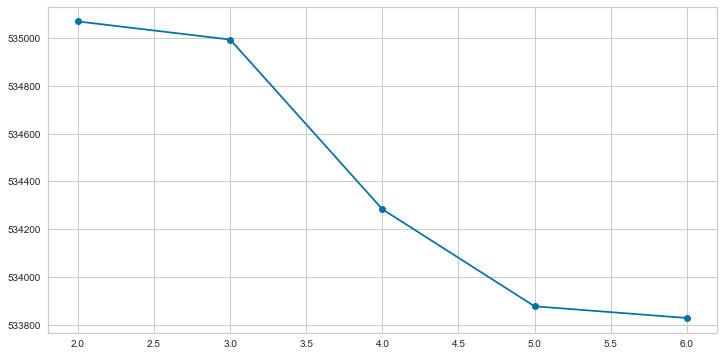

In [57]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [58]:
time_start = time.time()
optimal_k = min(zip(cluster_errors_bigram, list(cluster_range)))[1]
cluster_model_optimal = KMeans(optimal_k, n_jobs=6).fit(X_train)
print ('Clustering for Bigrams for optimal_k done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for Bigrams for optimal_k done! Time elapsed: 470.63013458251953 seconds


**Intercluster Distance Maps**

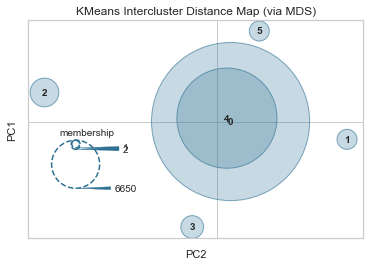

In [134]:
#To visialize the clusters in terms of inter and intra cluster distances.
#Size of each cluster is according to membership i.e number of points in the cluster.
#However, two clusters overlap in the 2D space, it does not imply that they overlap in the original feature space.
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering mod3el and visualizer
visualizer = InterclusterDistance(KMeans(optimal_k))

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [88]:
def wordcloud_per_cluster(X_train, cluster_model_optimal, X_train_preprocessed):
    pred_labels = cluster_model_optimal.predict(X_train)#Getting the predicted labels for every datapoint.
    words_clusterwise = []
    for label in np.unique(cluster_model_optimal.labels_):
        words_clusterwise = [X_train_preprocessed[i].split() for i in range(X_train.shape[0]) if label == pred_labels[i]]
        #words_clusterwise_text = words_clusterwise_text + " " + str(words_clusterwise)
        wordcloud = WordCloud(width = 800, height = 800,
                    max_words = 100,
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(str(words_clusterwise)) 
  
        # plot the WordCloud image                        
        plt.figure(figsize = (5, 5), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title("Cluster "+str(label))
      
        plt.show() 

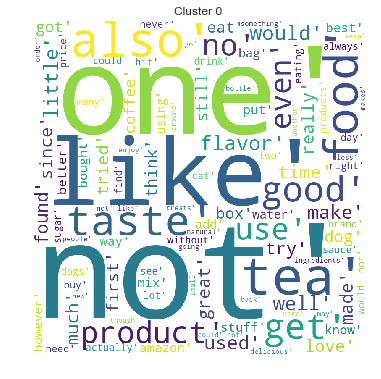

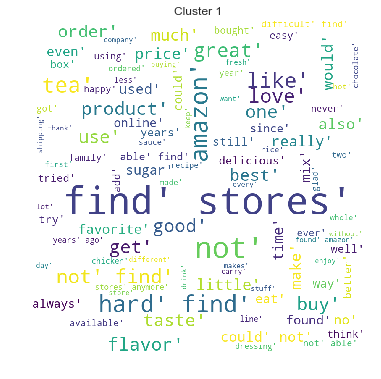

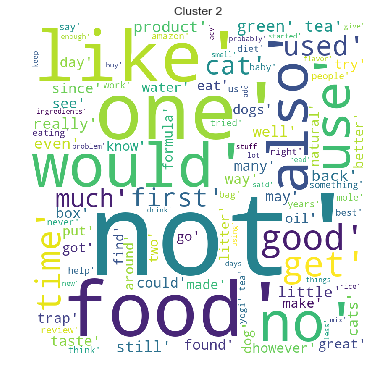

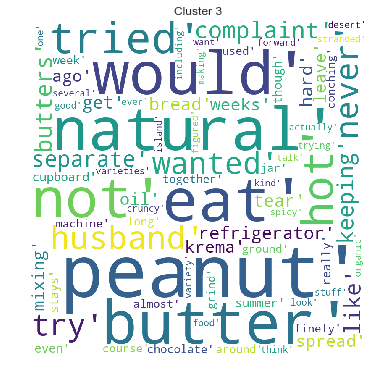

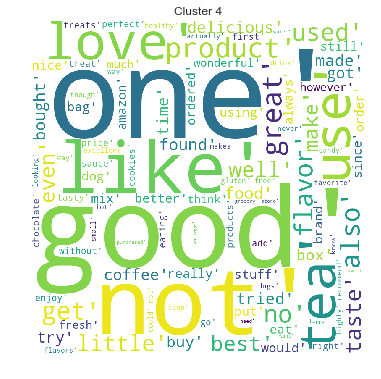

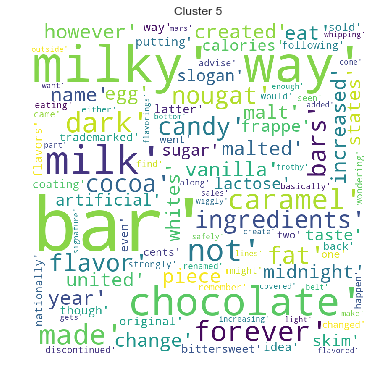

In [89]:
wordcloud_per_cluster(X_train, cluster_model_optimal, X_train_preprocessed)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [131]:
openPickleFile("X_train_TFIDF_sparse")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(50000, 28987)
float64


In [91]:
time_start = time.time()
cluster_errors_tfidf = []
cluster_range = range(2,7,1)
for num_clusters in cluster_range:
  clusters_tfidf = KMeans(num_clusters, n_jobs=6)
  clusters_tfidf.fit(X_train)
  cluster_errors_tfidf.append(clusters_tfidf.inertia_)

print ('Clustering for TFIDF for varying n_clusters done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF for varying n_clusters done! Time elapsed: 6187.590374708176 seconds


In [92]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors_tfidf } )

**Elbow curve to get the optimal k**

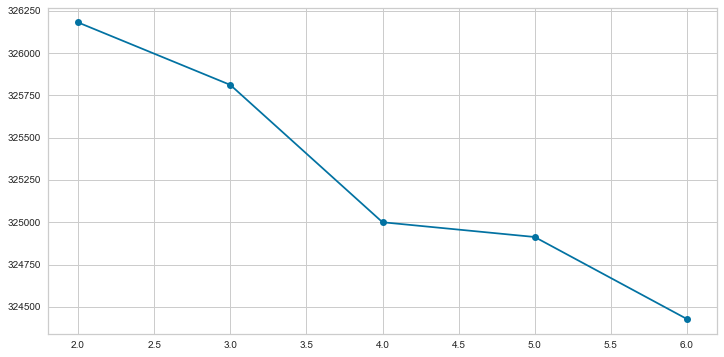

In [93]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [94]:
time_start = time.time()
optimal_k = min(zip(cluster_errors_tfidf, cluster_range))[1]
cluster_model_optimal_tfidf = KMeans(optimal_k, n_jobs=6).fit(X_train)
print ('Clustering for TFIDF for optimal_k done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF for optimal_k done! Time elapsed: 725.4698598384857 seconds


**Intercluster Distance Maps**

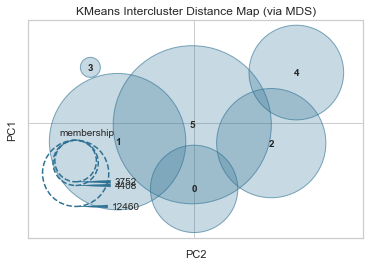

In [132]:
#To visialize the clusters in terms of inter and intra cluster distances.
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering mod3el and visualizer
visualizer = InterclusterDistance(KMeans(optimal_k))

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

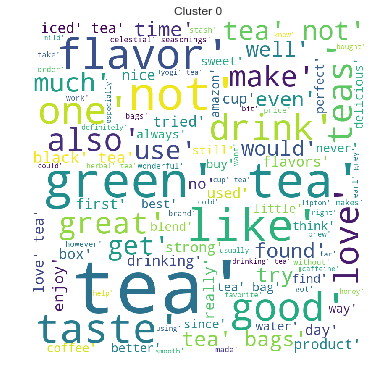

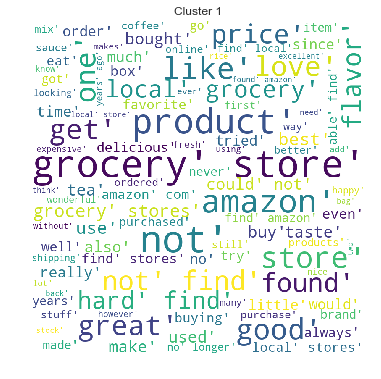

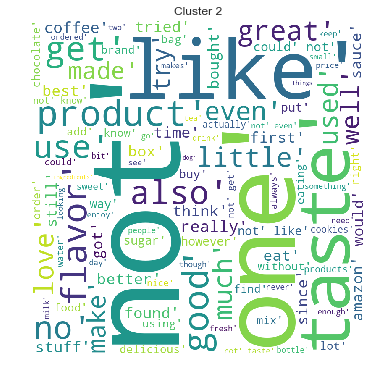

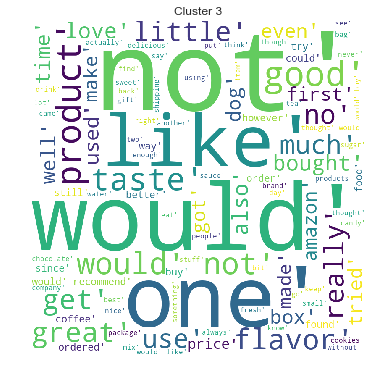

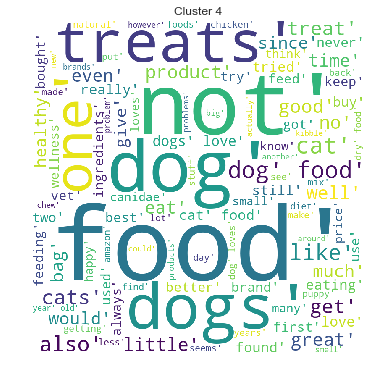

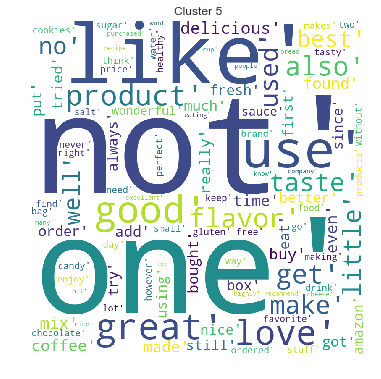

In [95]:
wordcloud_per_cluster(X_train, cluster_model_optimal_tfidf, X_train_preprocessed)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [119]:
openPickleFile("X_train_AVG_W2V_vectors")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(50000, 50)
float64


In [120]:
time_start = time.time()
cluster_errors_avgw2v = []
cluster_range = range(2,7)
for num_clusters in cluster_range:
  clusters_avgw2v = KMeans(num_clusters, n_jobs=6)
  clusters_avgw2v.fit(X_train)
  cluster_errors_avgw2v.append(clusters_avgw2v.inertia_)

print ('Clustering for AVG_W2V for varying n_clusters done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for AVG_W2V for varying n_clusters done! Time elapsed: 22.984572887420654 seconds


In [121]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors_avgw2v } )

**Elbow curve to get the optimal k**

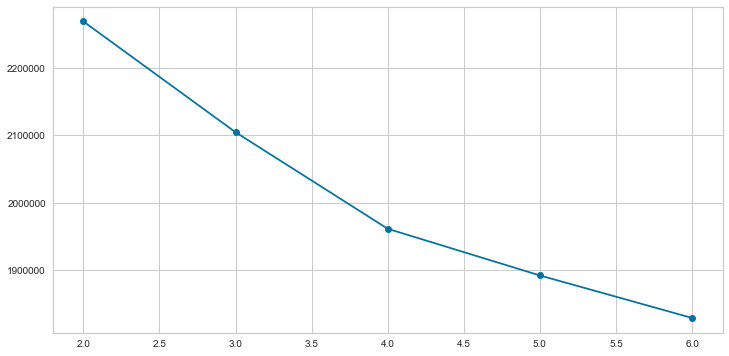

In [122]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [123]:
time_start = time.time()
optimal_k = min(zip(cluster_errors_avgw2v, cluster_range))[1]
cluster_model_optimal_avgw2v = KMeans(optimal_k, n_jobs=6).fit(X_train)
print ('Clustering for AVG_W2V for optimal_k done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for AVG_W2V for optimal_k done! Time elapsed: 7.798160552978516 seconds


**Intercluster Distance Maps**

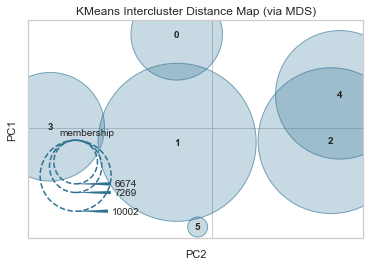

In [124]:
#To visialize the clusters in terms of inter and intra cluster distances.
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering mod3el and visualizer
visualizer = InterclusterDistance(KMeans(optimal_k))

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

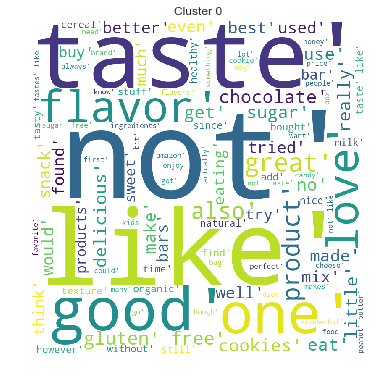

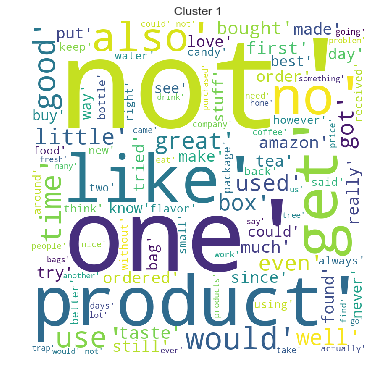

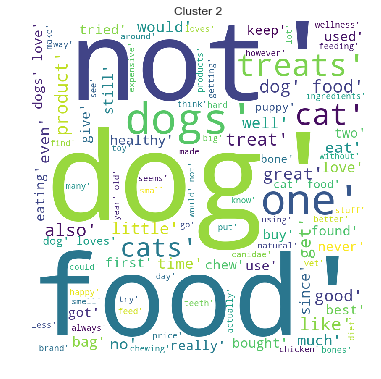

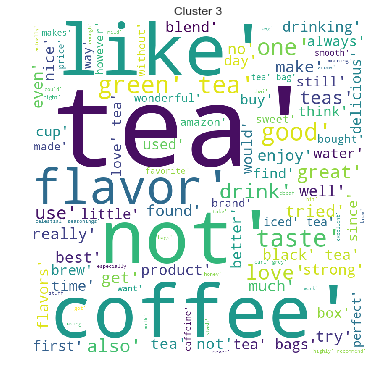

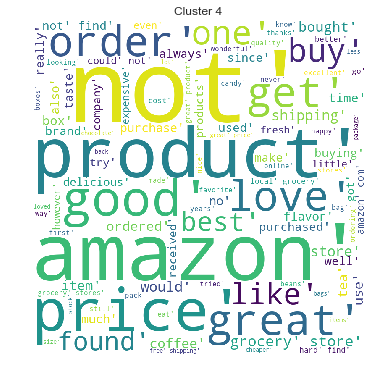

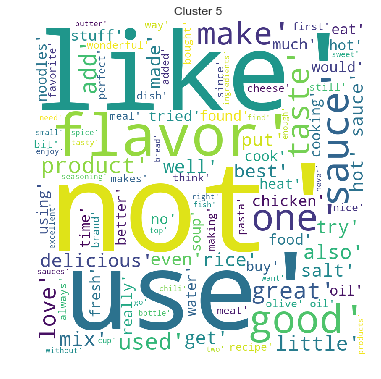

In [101]:
wordcloud_per_cluster(X_train, cluster_model_optimal_avgw2v, X_train_preprocessed)

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [125]:
openPickleFile("X_train_TFIDF_AvgW2V")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(50000, 50)
float64


In [126]:
time_start = time.time()
cluster_errors_tfidf_avgw2v = []
cluster_range = range(2,7)
for num_clusters in cluster_range:
  clusters_tfidf_avgw2v = KMeans(num_clusters, n_jobs=6)
  clusters_tfidf_avgw2v.fit(X_train)
  cluster_errors_tfidf_avgw2v.append(clusters_tfidf_avgw2v.inertia_)

print ('Clustering for TFIDF AVG_W2V for varying n_clusters done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF AVG_W2V for varying n_clusters done! Time elapsed: 22.230586528778076 seconds


In [127]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors_tfidf_avgw2v } )

**Elbow curve to get the optimal k**

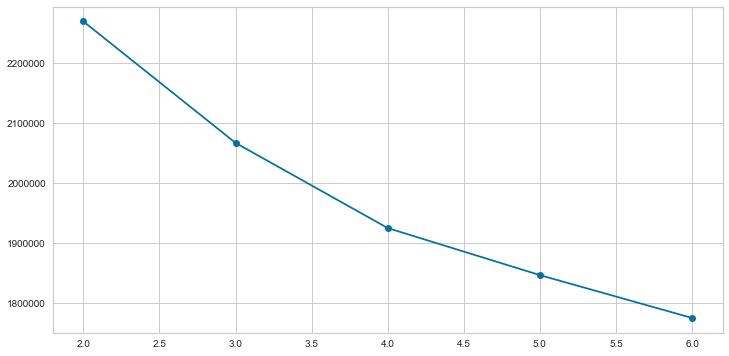

In [128]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [129]:
time_start = time.time()
optimal_k = min(zip(cluster_errors_tfidf_avgw2v, cluster_range))[1]
cluster_model_optimal_tfidf_avgw2v = KMeans(optimal_k, n_jobs=6).fit(X_train)
print ('Clustering for TFIDF AVG_W2V for optimal_k done! Time elapsed: {} seconds'.format(time.time()-time_start))

Clustering for TFIDF AVG_W2V for optimal_k done! Time elapsed: 5.934138774871826 seconds


**Intercluster Distance Maps**

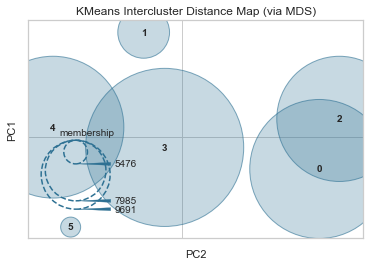

In [130]:
#To visialize the clusters in terms of inter and intra cluster distances.
from yellowbrick.cluster import InterclusterDistance

# Instantiate the clustering mod3el and visualizer
visualizer = InterclusterDistance(KMeans(optimal_k))

visualizer.fit(X_train) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

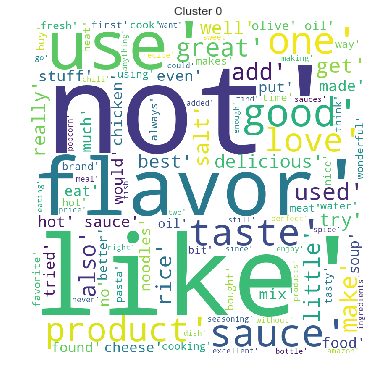

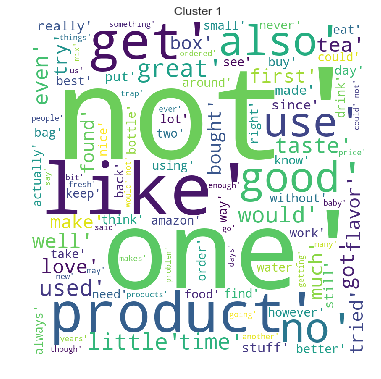

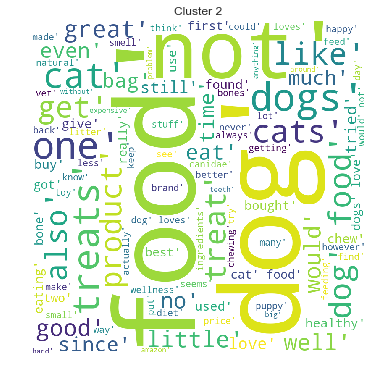

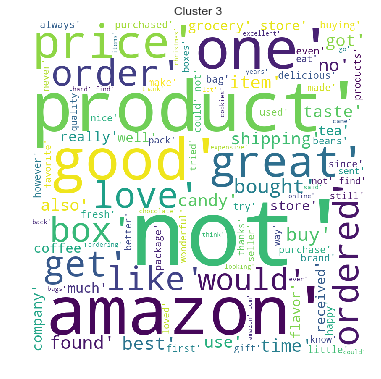

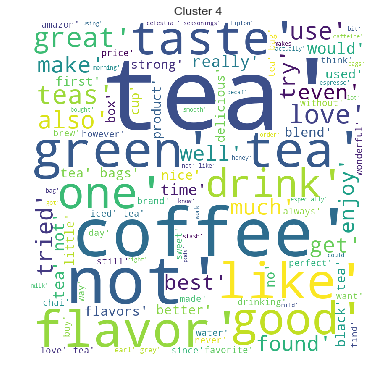

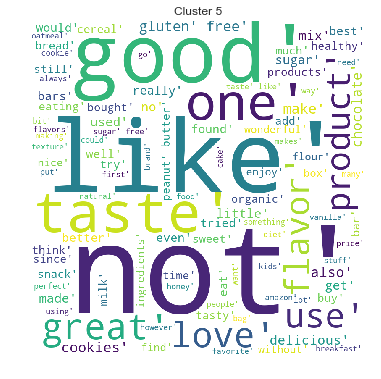

In [114]:
wordcloud_per_cluster(X_train, cluster_model_optimal_tfidf_avgw2v, X_train_preprocessed)

## [5.2] Agglomerative Clustering

In [171]:
#Taking 5k * 0.8428 positive reviews from cleaned SQLlite table final.

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 1
--ORDER BY RANDOM()
LIMIT 4214;
""", conn)

positive_reviews = display

In [172]:
#Taking 5k * 0.15720 negative reviews from cleaned SQLlite table final.
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score = 0
--ORDER BY RANDOM()
LIMIT 786;
""", conn)

negative_reviews = display

In [173]:
#Combining postive reviews and negative reviews
final5k = []
final5k = pd.concat([positive_reviews,negative_reviews], ignore_index=True)
final5k = final5k.sort_values('Time',ascending=True)

In [174]:
X_train = final5k['cleaned_text'].values
X_train_preprocessed_2 = X_train #Preprocessed train data will be used later.

In [175]:
#To pickle-out/save an object.
savePickleFile(X_train, "X_train_2")

# [5.2.1] Featurization

## [5.2.1.1] Word2Vec

**Vectorization of X_train**

In [176]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

In [177]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.9797375202178955), ('cheese', 0.970564603805542), ('wonderful', 0.9673775434494019), ('makes', 0.9648706316947937), ('drinkers', 0.9612823724746704), ('definitely', 0.9608489871025085), ('bit', 0.9580360651016235), ('delicious', 0.9566689133644104), ('enjoy', 0.956209123134613), ('really', 0.9546952247619629)]
[('kinds', 0.9993515610694885), ('cause', 0.9992238283157349), ('fine', 0.9992150664329529), ('gross', 0.9992150664329529), ('begin', 0.999131441116333), ('tartar', 0.9990640878677368), ('child', 0.9990416169166565), ('learned', 0.9990364909172058), ('discovered', 0.9990343451499939), ('nearly', 0.9990244507789612)]


In [178]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4775
sample words  ['little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'learned', 'india', 'roses', 'love', 'new', 'words', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'something', 'used', 'series', 'books', 'songs', 'teaching', 'turned', 'whole', 'school', 'purchasing', 'cd', 'children', 'tradition', 'lives', 'beetlejuice']


## [5.2.1.2] Converting text into vectors using Avg W2V, TFIDF-W2V

####  [5.2.1.2.1] Avg W2v

In [179]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 5000/5000 [00:06<00:00, 781.99it/s]


5000
50


**Standardization of AvgW2V of X_train**

In [180]:
# Data-preprocessing: Standardizing the data
standardized_avg_w2v_train = StandardScaler().fit_transform(sent_vectors)

#Storing the standardized data into a pickle file for future use.
savePickleFile(standardized_avg_w2v_train, "X_train_AVG_W2V_vectors_2")

#### [5.2.1.2.2] TFIDF weighted W2v

**Training of X_train for TFIDF**

In [181]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [182]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentence=[]
for sentence in X_train:
    list_of_sentence.append(sentence.split())

**Training of X_train for TFIDF AVGW2V**

In [183]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 5000/5000 [00:36<00:00, 138.31it/s]


**Standardization of TFIDF AvgW2V of X_train**

In [184]:
# Data-preprocessing: Standardizing the data
standardized_tfidf_avg_w2v_train = StandardScaler().fit_transform(tfidf_sent_vectors)

#Storing the standardized_tfidf_sent_vectors_array data into a pickle file for future use.
savePickleFile(standardized_tfidf_avg_w2v_train, "X_train_TFIDF_AvgW2V_2")

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [459]:
openPickleFile("X_train_AVG_W2V_vectors_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(5000, 50)
float64


In [461]:
clusters_avg_w2v = AgglomerativeClustering(5)
clusters_avg_w2v.fit(X_train)
pred_labels = clusters_avg_w2v.labels_

In [463]:
print(clusters_avg_w2v.labels_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, pred_labels))

[0 0 0 ... 0 1 3]
Silhouette Coefficient: 0.203


**Dendograms**

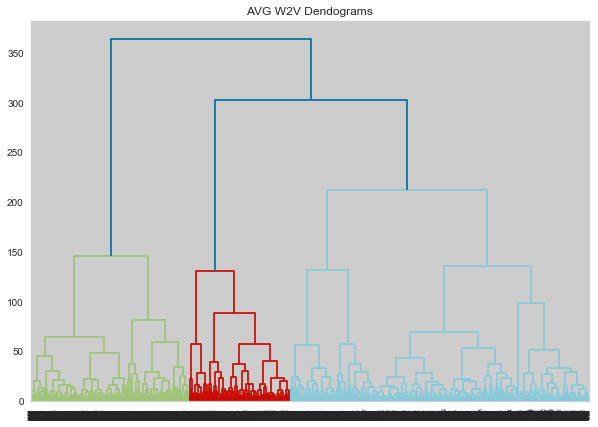

In [188]:
#To view the dendograms for Agglomerative clustering.
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("AVG W2V Dendograms")  
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))

It can be inferred that there are majorly 3 clusters that represented as dark blue lines.

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

In [192]:
def wordcloud_cluster_wise(X_train, cluster_model, pred_labels, X_train_preprocessed):
    words_clusterwise = []
    for label in np.unique(cluster_model.labels_):
        words_clusterwise = [X_train_preprocessed[i].split() for i in range(X_train.shape[0]) if label == pred_labels[i]]
        wordcloud = WordCloud(width = 800, height = 800,
                    max_words = 100,
                    background_color ='white', 
                    stopwords = None, 
                    min_font_size = 10).generate(str(words_clusterwise)) 
  
        # plot the WordCloud image                        
        plt.figure(figsize = (5, 5), facecolor = None) 
        plt.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        plt.title("Cluster "+str(label))
      
        plt.show() 

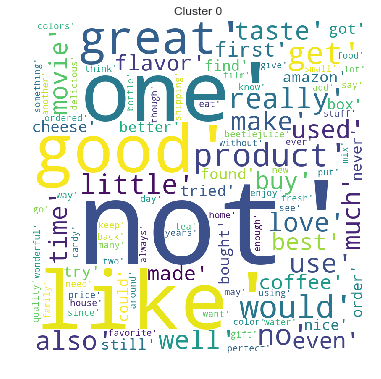

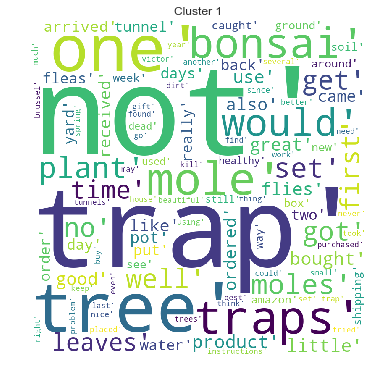

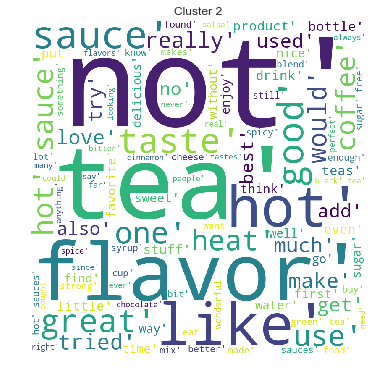

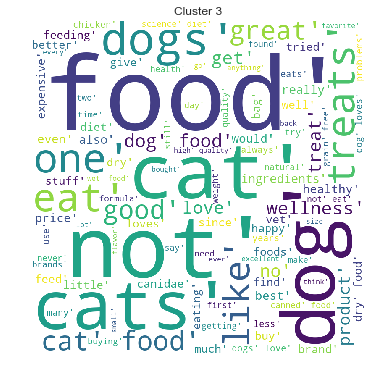

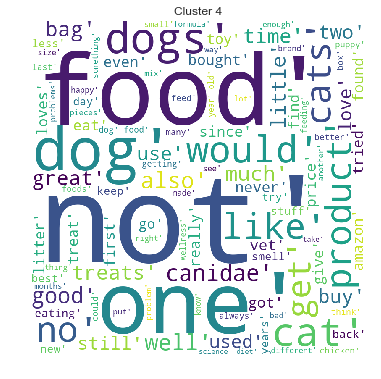

In [193]:
wordcloud_cluster_wise(X_train, clusters_avg_w2v, pred_labels, X_train_preprocessed_2)

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [464]:
openPickleFile("X_train_TFIDF_AvgW2V_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(5000, 50)
float64


In [465]:
clusters_tfidf_avg_w2v = AgglomerativeClustering(5)
clusters_tfidf_avg_w2v.fit(X_train)
pred_labels = clusters_tfidf_avg_w2v.labels_

In [466]:
print(clusters_avg_w2v.labels_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, pred_labels))

[0 0 0 ... 0 1 3]
Silhouette Coefficient: 0.211


**Dendograms**

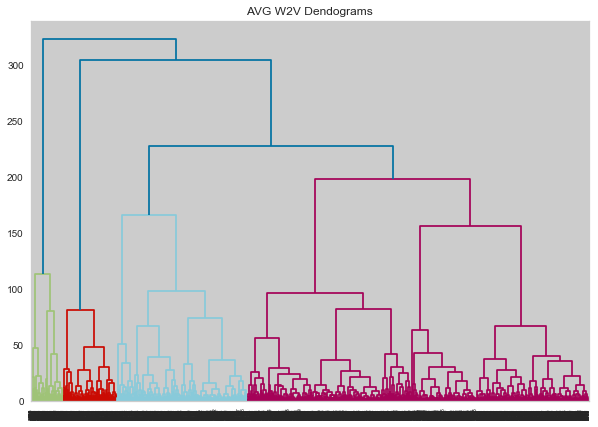

In [197]:
#To view the dendograms for Agglomerative clustering.
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("AVG W2V Dendograms")  
dend = shc.dendrogram(shc.linkage(X_train, method='ward'))

It can be inferred that there are majorly 4 clusters that are represented as dark blue lines.

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

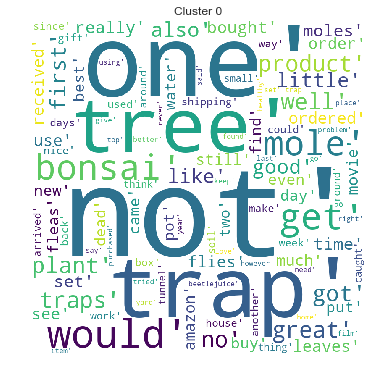

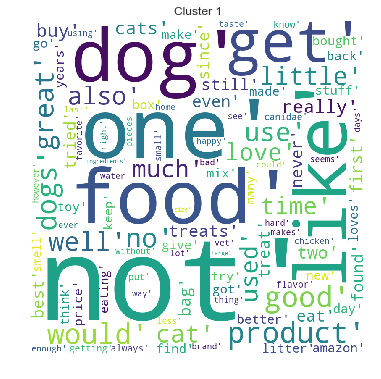

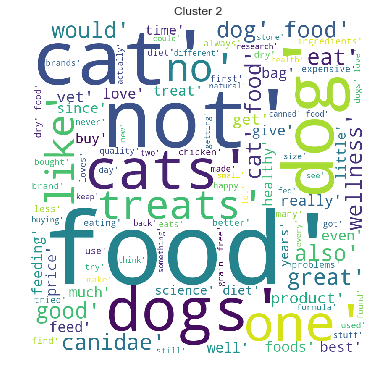

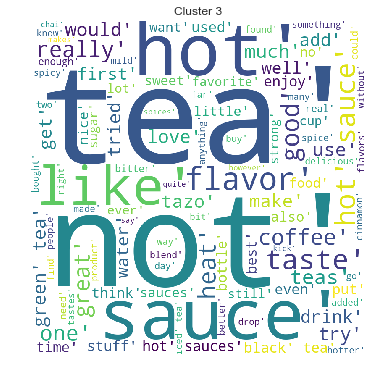

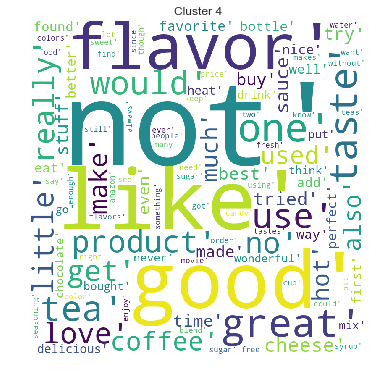

In [199]:
wordcloud_cluster_wise(X_train, clusters_tfidf_avg_w2v, pred_labels, X_train_preprocessed_2)

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [416]:
openPickleFile("X_train_AVG_W2V_vectors_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(5000, 50)
float64


In [417]:
time_start = time.time()
silhouette_score_avgw2v = []
eps_range_valid = []
eps_range = range(1, 15)#Varying eps to get the best silhouette score.
for eps in eps_range:
    clusters_avgw2v = DBSCAN(eps=eps, min_samples=100) #min_samples fixed at 100.
    clusters_avgw2v.fit(X_train)
    if len(np.unique(clusters_avgw2v.labels_)) > 1: #considering only those eps that lead to clusters > 1.
        eps_range_valid.append(eps)
        #silhoutte score requires atleast 2 labels/clusters to calculate inter and intra cluster distances.
        silhouette_score_avgw2v.append(metrics.silhouette_score(X_train, clusters_avgw2v.labels_))

print ('DBSCAN Clustering for AVG_W2V for varying eps done! Time elapsed: {} seconds'.format(time.time()-time_start))

DBSCAN Clustering for AVG_W2V for varying eps done! Time elapsed: 71.63455510139465 seconds


In [418]:
clusters_df = pd.DataFrame( { "eps":eps_range_valid, "silhouette_score": silhouette_score_avgw2v } )

**Elbow curve to get the optimal eps**

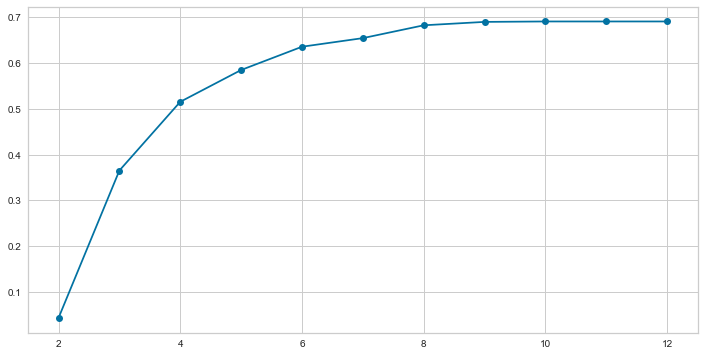

In [419]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.eps, clusters_df.silhouette_score, marker = "o" )

In [420]:
#To get the optimal eps for max silhouette score.
optimal_eps = max(zip(silhouette_score_avgw2v, eps_range_valid))[1]
optimal_eps

12

In [441]:
clusters_avgw2v = DBSCAN(eps=3, min_samples=100) #Taking eps=3 to get a well distributed wordcloud.
clusters_avgw2v.fit(X_train)
pred_labels = clusters_avgw2v.labels_

In [442]:
print(np.unique(clusters_avgw2v.labels_))
print(clusters_avgw2v.core_sample_indices_)
print(clusters_avgw2v.components_.shape)

[-1  0]
[   2    3    4 ... 4996 4997 4999]
(3045, 50)


In [443]:
#Function to count no. of unique values in variable of any datatype.
def unique_count(a):
    unique, inverse = np.unique(a, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    return np.vstack(( unique, count)).T
unique_count(clusters_avgw2v.labels_)

array([[  -1,  646],
       [   0, 4354]], dtype=int64)

In [444]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_train, pred_labels))

Silhouette Coefficient: 0.365


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

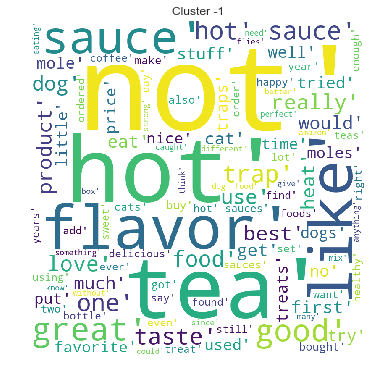

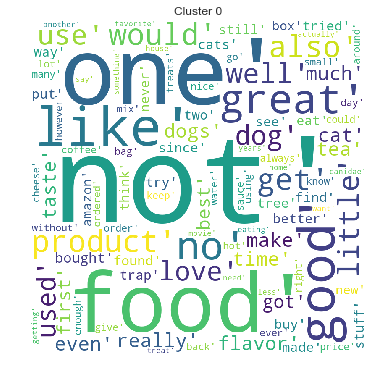

In [445]:
wordcloud_cluster_wise(X_train, clusters_avgw2v, pred_labels, X_train_preprocessed_2)

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [446]:
openPickleFile("X_train_TFIDF_AvgW2V_2")
X_train = temp
print(X_train.shape)
print(X_train.dtype)

(5000, 50)
float64


In [447]:
time_start = time.time()
silhouette_score_tfidf_avgw2v = []
eps_range_valid = []
eps_range = range(1, 15)#Varying eps to get the best silhouette score.
for eps in eps_range:
    clusters_tfidf_avgw2v = DBSCAN(eps=eps, min_samples=100) #min_samples fixed at 100.
    clusters_tfidf_avgw2v.fit(X_train)
    if len(np.unique(clusters_tfidf_avgw2v.labels_)) > 1: #considering only those eps that lead to clusters > 1.
        eps_range_valid.append(eps)
        #silhoutte score requires atleast 2 labels/clusters to calculate inter and intra cluster distances.
        silhouette_score_tfidf_avgw2v.append(metrics.silhouette_score(X_train, clusters_tfidf_avgw2v.labels_))

print ('DBSCAN Clustering for AVG_W2V for varying eps done! Time elapsed: {} seconds'.format(time.time()-time_start))

DBSCAN Clustering for AVG_W2V for varying eps done! Time elapsed: 63.37662744522095 seconds


In [448]:
clusters_df = pd.DataFrame( { "eps":eps_range_valid, "silhouette_score": silhouette_score_tfidf_avgw2v } )

**Elbow curve to get the optimal eps**

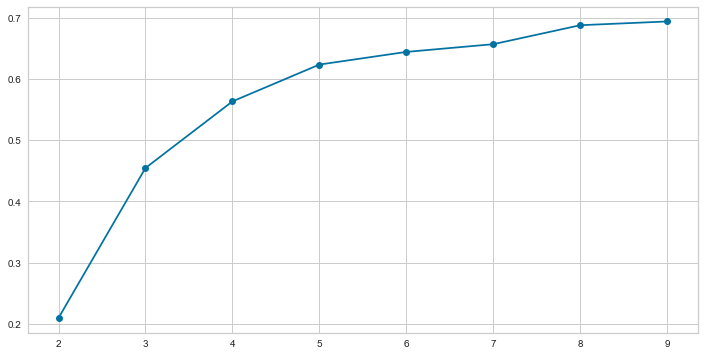

In [449]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.eps, clusters_df.silhouette_score, marker = "o" )

In [450]:
#To get the optimal eps for max silhouette score.
optimal_eps = max(zip(silhouette_score_tfidf_avgw2v, eps_range_valid))[1]
optimal_eps

9

In [451]:
clusters_tfidf_avgw2v = DBSCAN(eps=5, min_samples=100)#Taking eps=5 to get a well distributed wordcloud.
clusters_avgw2v.fit(X_train)
pred_labels = clusters_avgw2v.labels_

DBSCAN Clustering for TFIDF AVG_W2V for optimal eps done! Time elapsed: 3.62233304977417 seconds


In [453]:
unique_count(clusters_avgw2v.labels_)

array([[  -1,  596],
       [   0, 4404]], dtype=int64)

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

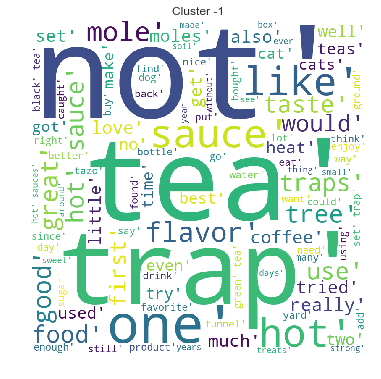

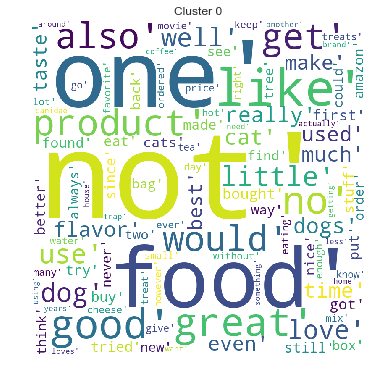

In [455]:
wordcloud_cluster_wise(X_train, clusters_tfidf_avg_w2v, pred_labels, X_train_preprocessed_2)

# [6] Conclusions

In [476]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "inertia"]

x.add_row(["BOW(Bigrams)", "K-means", "n_clusters=6", 534000])
x.add_row(["TFIDF", "K-means", "n_clusters=6", 324000])
x.add_row(["Avg W2V", "K-means", "n_clusters=6", 184000])
x.add_row(["TFIDF Avg W2V", "K-means", "n_clusters=6", 175000])

print(x)

+---------------+---------+----------------+---------+
|   Vectorizer  |  Model  | Hyperparameter | inertia |
+---------------+---------+----------------+---------+
|  BOW(Bigrams) | K-means |  n_clusters=6  |  534000 |
|     TFIDF     | K-means |  n_clusters=6  |  324000 |
|    Avg W2V    | K-means |  n_clusters=6  |  184000 |
| TFIDF Avg W2V | K-means |  n_clusters=6  |  175000 |
+---------------+---------+----------------+---------+


In [479]:
y = PrettyTable()

y.field_names = ["Vectorizer", "Model", "Hyperparameter", "silhouette score"]

y.add_row(["Avg W2V", "Agglomerative", "n_clusters=5", 0.203])
y.add_row(["TFIDF Avg W2V", "Agglomerative", "n_clusters=5", 0.211])
y.add_row(["Avg W2V", "DBScan", "n_clusters=12", 0.691])
y.add_row(["TFIDF Avg W2V", "DBScan", "n_clusters=9", 0.691])

print(y)

+---------------+---------------+----------------+------------------+
|   Vectorizer  |     Model     | Hyperparameter | silhouette score |
+---------------+---------------+----------------+------------------+
|    Avg W2V    | Agglomerative |  n_clusters=5  |      0.203       |
| TFIDF Avg W2V | Agglomerative |  n_clusters=5  |      0.211       |
|    Avg W2V    |     DBScan    | n_clusters=12  |      0.691       |
| TFIDF Avg W2V |     DBScan    |  n_clusters=9  |      0.691       |
+---------------+---------------+----------------+------------------+
